# DATASET 과 DATALOADER
데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수도 있습니다.
더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다.
Pytorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두가지 데이터 기본 요소를 제공하여 미리 준비해돈 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다. Dataset은 샘플과 정답을 저장하고, DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감쌉니다.

Pytorch는 도메인 특화 라이브러리들은 (FashionMNIST) 미리 준비해둔 다양한 데이터셋을 제공합니다.
데이터셋은 torch.utils.data.Dataset의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있습니다. 이러한 데이터셋은 모델을 만들어보고 prototype 성능을 측정(benchmark) 하는 데 사용할 수 있습니다.

# 데이터셋 불러오기
TorchVision에서 Fashion-MNIST 데이터셋을 불러오는 예제를 살펴보겠습니다.
Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있으며, 각 예제는 grayscale의 28x28이미지와 10개 분류 중 하나인 정답으로 구성됩니다.

다음 매개변수들을 사용하여 FashionMNIST 데이터셋을 불러옵니다:


*   root 는 학습/데이터가 저장되는 경로 입니다.
*   train은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.
*   download = True는 root에 데이터가 없는 경우 인터넷에서 다운로드 합니다.
*   transform과 target_transform은 특징과 정답 변형을 지정합니다.



In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root = "./data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.FashionMNIST(
    root = "./data",
    train = False,
    download = True,
    transform = ToTensor()
)

# 데이터셋을 순회하고 시각화하기
Dataset에 리스트처럼 직접 접근할 수 있습니다: training_Data[index], matplotlib 을 사용하여 학습 데이터 일부를 시각화 해보겠습니다.

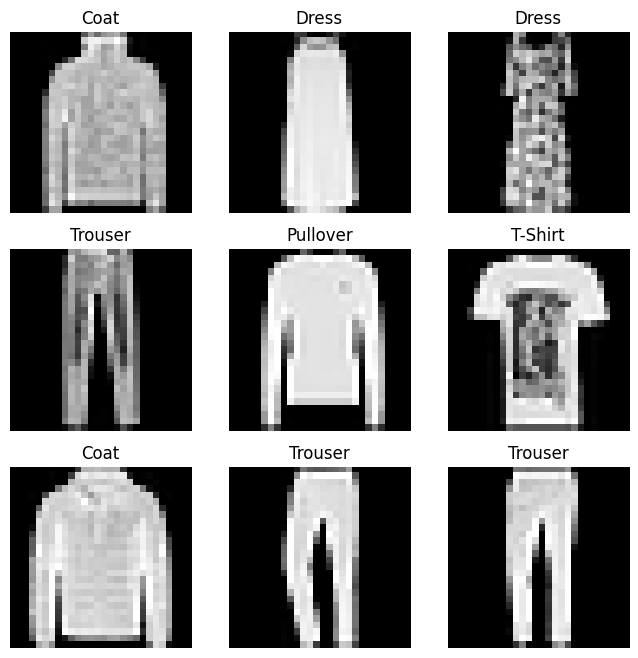

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize =(8,8))
cols, rows = 3,3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size =(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#  __init__
__init__ 함수는 Dataset 객체가 생성될때 한 번만 실행됩니다. 여기서는 이미지와 주석파일이 포함된 디렉토리와 두가지 변형을 초기화 합니다.

# __len__
__len__ 함수는 데이터셋의 샘플 개수를 반환합니다.


# __getitem__
__getitem__ 함수는 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다.
인덱스를 기반으로, 디스트에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고, self.img_lables의 csv 데이터로부터 해당하는 정답(label)을 가져오고, 변형함수들을 호출한 뒤, 텐서 이미지와 라벨 Python사전형으로 변환합니다.

# DataLoader로 학습용 데이터 준비하기
Dataset은 데이터셋의 특징을 가져오고 하나의 샘플에 정답을 지정하는 일을 한번에 합니다.
모델을 학습할 때, 일반적으로 샘플들을 minibatch로 전달하고, 매 에폭마다 데이터를 다시 섞어서 overfit을 막고, Python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 합니다.

DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체 입니다.


In [7]:
from torch.utils.data import DataLoader
train_dataLoader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataLoader = DataLoader(test_data, batch_size = 64, shuffle = True)

# DataLoader를 통해 순회하기(iterate)
DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회할 수 있습니다. 아래의 각 iteration은 (각각 batch_size = 64의 특징과 정답을 포함하는) train_features와 train_labels의 묶음(batch)를 반환합니다. shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


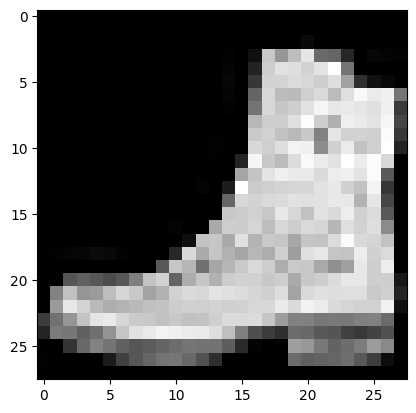

Labels: 9


In [9]:
train_features, train_labels = next(iter(train_dataLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Labels: {label}")